# Note : Most of my project was done using google colab. Run this in google before you import in pandas to prevent your notebook from slowing down on breaking. It's also free .Thank you.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1onto1Fh1pykXRomW2sllRTytw9ut1jzv'}) # replace the id with id of file you want to access
downloaded.GetContentFile('PS_20174392719_1491204439457_log.csv') 


# Explaining the variables in the DataFrame

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
![](creditcard.jpeg)


# Project Steps

In [ ]:

- 1.Loading Data and EDA
- 2.Feature Engineering
- 3.Machine Learning
    - 3.1. Baseline Models
    - 3.2. Grid Search for Best Hyper-parameter
    - 3.3. Dealing with Unbalanced Data
    - 3.3.1. Balancing Data via Resambling with SMOTE
    - 3.3.2. Subsampling Data from the Original Dataset
    - 3.3.3 Performing SMOTE on the New Data
    - 3.3.3a HyperParameter Optimization And Visualization of ROC_Curve of Models
             RandomForestModel and XGBoost Model

- 4.Machine Learning Pipeline
- 5.Feature Importance
- 6.Conclusion

# Loading Libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# 1. Loading Data and EDA

In [0]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv.zip" , compression = "zip")
df.head()

In [6]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df.shape

(6362620, 11)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
df.isnull().any().any()

False

In [10]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Checking for duplicates

In [0]:
df.duplicated(keep = "first").any()

False

# From the above lets see which Columns are Categorical and numerical

# Finding the numerical columns

In [0]:
cat_cols = list(set(df.columns) - set(df._get_numeric_data().columns))
cat_cols

['nameDest', 'type', 'nameOrig']

# Finding the categorical columns

In [0]:
num_cols = list(set(df._get_numeric_data().columns))
num_cols

['isFraud',
 'isFlaggedFraud',
 'oldbalanceDest',
 'newbalanceOrig',
 'oldbalanceOrg',
 'newbalanceDest',
 'step',
 'amount']

# After investigating each column to see what each column entails lets have a look at a few important columns

In [0]:
df.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

# Lets check the distribution frequency distribution of the type of transaction column

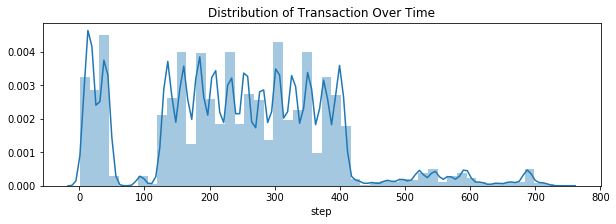

CPU times: user 1.17 s, sys: 31.2 ms, total: 1.21 s
Wall time: 1.24 s


In [0]:
%%time
plt.figure(figsize =(10,3))
sns.distplot(df.step)
plt.title("Distribution of Transaction Over Time")
plt.show()

# Observations

Distrubition plot shows number of transactions occured each hour (step). There are drastic changes in the number of transactions occuriing from time to time. 

# Examining the data labels for fraud and safe transaction

In [0]:
safe = df[df["isFraud"] == 0]
fraud = df[df["isFraud"] == 1]

# Lets check the frequency distribution

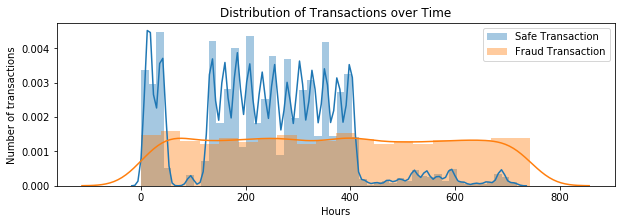

In [0]:
plt.figure(figsize = (10,3))
sns.distplot(safe.step , label = "Safe Transaction")
sns.distplot(fraud.step , label = "Fraud Transaction")
plt.xlabel("Hours")
plt.ylabel("Number of transactions")
plt.title("Distribution of Transactions over Time")
plt.legend()
plt.show()

# Observations : we can see that after 72 hours and 90 hours and after 400 hours during the month , the fraud transctions occur at a steady pace. 

# Lets have a look at the hourly transactions for each amount

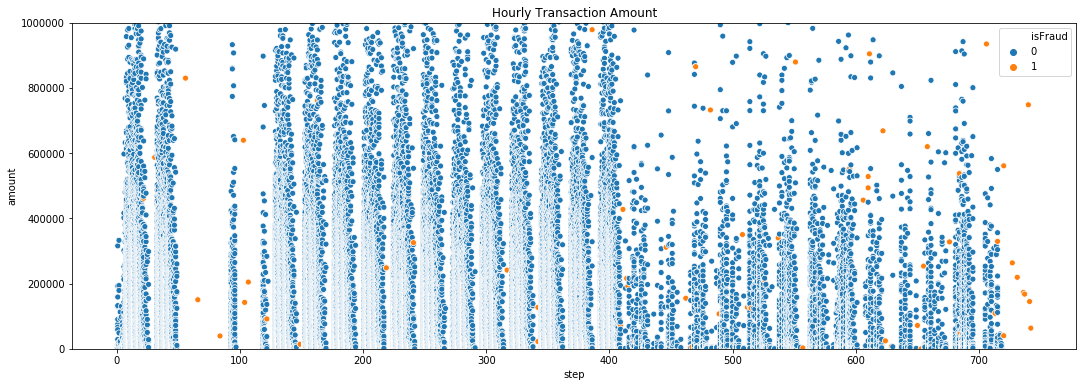

In [0]:
new_df = df.sample(n=100000 , random_state = 1)
new_df = new_df.sort_index()
new_df = new_df.reset_index(drop = True)
#lets plot the small data
plt.figure(figsize = (18,6))
plt.ylim(0 , 1000000) #Here i set the limit on the yaxis to 1Million
plt.title("Hourly Transaction Amount")
ax = sns.scatterplot(x = "step" , y = "amount" , hue = "isFraud" , data = new_df)

**Observation** :
- The plot indicates some sort of seasonality in the number of transaction during the day. A pattern is observed every 24 hour ;however , we do not know what time of the day fully represents "0" represents on the graph but a higher transaction clusters around the middle of the 24hour period.

# Lets Visualize if fraud transaction has the score/similar pattern. The hourly amount of all fraud transactions.

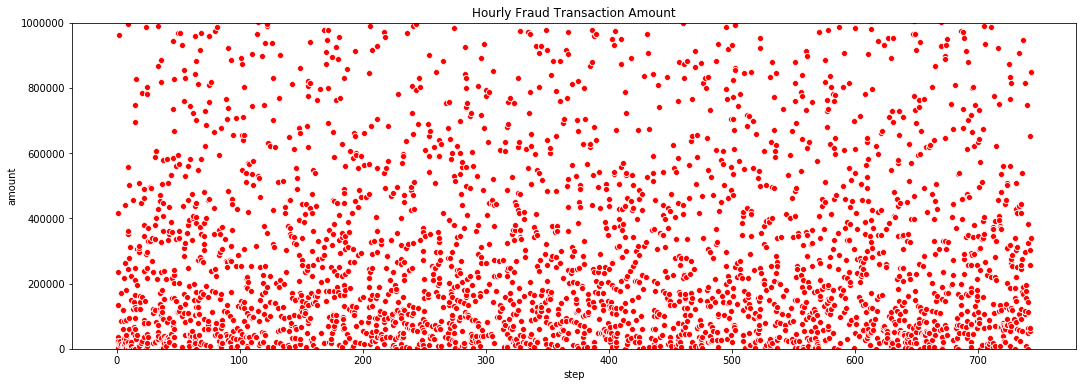

In [0]:
plt.figure(figsize = (18 , 6))
plt.ylim(0 , 1000000)
plt.title("Hourly Fraud Transaction Amount")
ax = sns.scatterplot(x = "step" , y = "amount" ,color = "r" ,  data = fraud)

# Observations:

- We can see that the fraudlent transactions do not show a significant pattern as compared to the graph of the safe transactions in terms of number of occurence. 
- The fraudulent tranactions occur almost every hour at the same frequency . There are more fraud transactions in low amounts and less in high amounts. However , there are no changes in the pattern. 

# Transaction Amount Distribution
Safe transaction amount

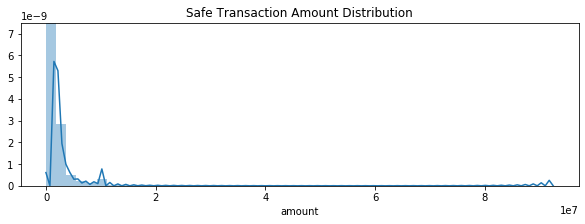

In [0]:
plt.figure(figsize =(10,3))
plt.ylim(0 , 0.0000000075)
plt.title("Safe Transaction Amount Distribution")
sns.distplot(safe.amount)
plt.title("Safe Transaction Amount Distribution")
plt.show()


**Observations**:
 - We can see that the safe transactions are in very low amounts ;however , there is a peek in $1M but above that the frequency decreases

# Lets have a look at the descriptive statistics of the safe amounts

In [0]:
safe.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

# Fraud transactions amount distribution plot

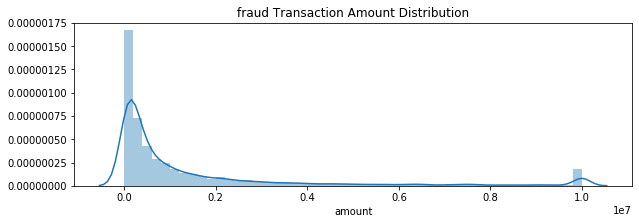

In [0]:
plt.figure(figsize = (10,3))
plt.title("fraud Transaction Amount Distribution")
sns.distplot(fraud.amount)

# Observation:
There is an interesting peak on $1m. `let's investigate a bit more on how many fraudent transactions happenning at $1m`

fraudulent value counts

In [0]:
fraud.amount.value_counts()

10000000.00    287
0.00            16
429257.45        4
1165187.89       4
76646.05         2
              ... 
3576297.10       1
23292.30         1
1078013.76       1
112486.46        1
4892193.09       1
Name: amount, Length: 3977, dtype: int64

# Observation:


 `We can see that fraudulent cases of $1M occurred 287 times and this is the maximum amount`.
    
 `Also there is an interesting amount of 0.00 which occured 16 times`
 
 Also a few amounts have been flagged as fraudulent transactions

# Fraud transaction boxplot for the amount distribution 

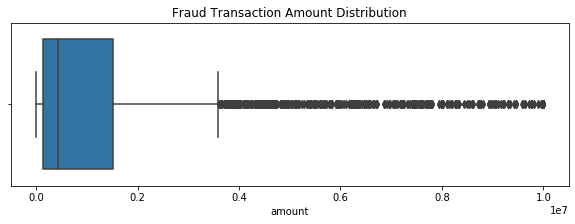

In [0]:
plt.figure(figsize = (10,3))
plt.title("Fraud Transaction Amount Distribution")
ax = sns.boxplot(x = fraud['amount'])

# Let's check the stats description of the fraud amounts

In [0]:
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

# Observations:

Most of the fraud occured below $400K. Lets's investigate on the average amount for those transactions

# Average amount of fraud below  400,000 Dollars

In [0]:
fraud[fraud.amount < 400000].amount.mean()

144912.16828933996

# Overall Observations:

Fraud transactions happen in large range from $119 to &10M. The frequency distribution of the amount of money involved in fraud transactions is positively skewed. Most of the fraud transactions are small amounts.

Majority of fraudulent transactions are lower than $1M .  
`However in $1M there is an interesting increase similar to safe transactionsand that is also the maximum amount in all fraud transactions`. There are also the maximum amount in all fraud transactions. 
There are also some fraud labelled transactions that have 0 amount.
There are also 16 of these transactions.
    


# Lets check for '0' ie Zeros in fraud amount as discovered in EDA

In [0]:
fraud[fraud.amount == 0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


In [0]:
print(len(fraud[fraud.amount == 0]))

16


# Observation:

There are a few discrepencies in this DataFrame. We can see that 16 transactions were recorded as fraud 
;however , the fraud amount is 0. There might be something going on that isnt allowing us to detect the 
fraudulent transactions . Perhaps high volumne oftransactions traffic that makes real fraud to go unnoticed.
`Unless it is an inside job` . For this reason , further investigation would need to be done later. 

In [0]:
#Type of transactions

In [0]:
safe["type"].value_counts()

CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64

# Visualisation of safe type of transactions

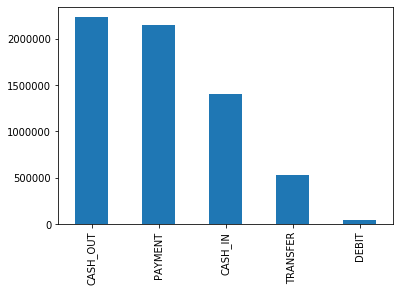

In [0]:
safe.type.value_counts().plot(kind = "bar")

# lets have a look at the fraud transaction types

In [0]:
fraud1 = fraud.groupby(fraud['type'])


In [0]:
# gridsearch(estima)

In [0]:
fraud1 = fraud.groupby(fraud['type']).mean()
fraud1

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
type,,,,,,,,
CASH_OUT,367.720360,1.455103e+06,1.453869e+06,72.586883,1.084918e+06,2.549545e+06,1.0,0.000000
TRANSFER,369.110569,1.480892e+06,1.846374e+06,385604.568626,1.073383e+03,3.981411e+03,1.0,0.003905


<Figure size 720x216 with 0 Axes>

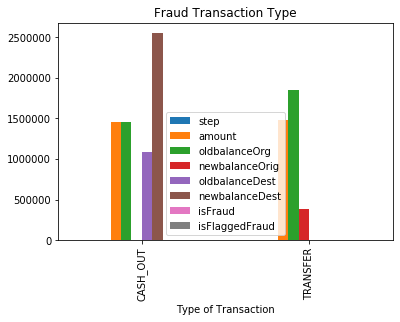

In [0]:
plt.figure(figsize = (10,3))
fraud1.plot(kind = 'bar')
plt.title("Fraud Transaction Type")
plt.xlabel("Type of Transaction")
plt.legend()
plt.show()

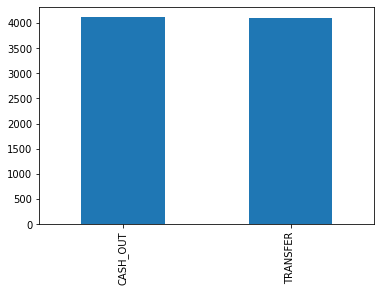

In [0]:
fraud['type'].value_counts().plot(kind = "bar")

# Observations

We can see that all the fraudulent transactions are only with cash_outs and Trasnfers. Debit usage is very safe.
Therefore it is best to use only the Cash_Out and Transfer Data for the model since the other type of transactions
have no fraudulent activities involved.

# Business Recommedation

Cameras should be installed at Vantage points and at collection points. Perhaps facial recognition cameras should
be installed in order to get hold of the culprits. Also there should be a limit on withdrawals and money transfers

Further this is why i am building a model to flag all fraudulent transactions.

# Rate of Fraud transactions

In [0]:
df.isFraud.value_counts()[1]/(df.isFraud.value_counts()[0] + df.isFraud.value_counts()[1])

0.001290820448180152

# Observation:

- Fraud transactions are only 0.01% of the safe transactions.
- Target class is pretty skewed and this might be a problem for the model.

# Proportion of Fraud Amount

In [0]:
fraud["amount"].sum()/(safe["amount"].sum() + fraud["amount"].sum())

0.010535206008606473

# Observation:

- Total money stolen is 0.1% of safe transaction amount

# Lets examine the IsFlagged Column - This is the column where fraud was actually discovered

In [0]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [0]:
fraud1 = fraud.groupby(fraud['type']).mean()

In [0]:
isFlaggedFraud1 = df.groupby(df["isFlaggedFraud"]).mean()

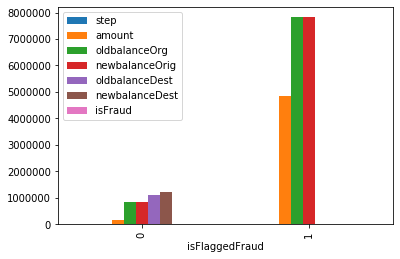

In [0]:
isFlaggedFraud1.plot(kind="bar")

In [0]:
df["isFlaggedFraud"].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

# Observation

There are only 16 positive values of fraud transactions flagged . Lets find which ones they are.

In [0]:
df[df['isFlaggedFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


# Observations:

Only 16 transactions were postively flagged fraud and all of them happend to be Transfers. All positive values
on the isFlaggedFraud are also positive on isFraud column. There are also inconsistencies in Origin and 
destination balances on these instances.
Maybe that is why they were marked Fraud. That is valuable information to keep too.

# 2. Feature Engineering

- First only get the transfer and cash out transaction data.
  Since fraud transactions happen only in these two type of transaction. Therefore, it is reasonable to only use
  this data  

In [0]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [0]:
#Subsetting so as to use columns where fraud transactions happen only in these two type of columns

In [0]:
df_type = df[df["type"].isin(["TRANSFER","CASH_OUT"])]

# Get 100000 samples from the filtered data

The data is too massive to work with so I am randomly sampling from the dataframe just big enough to build an ML
Model. Also Note that the subsetting is done where the type of fraud transaction was cash out and transfer

In [13]:
df1 = df_type.sample(n=100000 , random_state = 1)
df1 = df1.sort_index()
df1 = df1.reset_index(drop = True)
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,CASH_OUT,136872.92,C1533123860,162075.98,25203.05,C766572210,217806.00,0.00,0,0
1,1,TRANSFER,367768.40,C288306765,0.00,0.00,C1359044626,370763.10,16518.36,0,0
2,1,CASH_OUT,81029.86,C324112183,0.00,0.00,C288665596,105343.00,8496.61,0,0
3,1,CASH_OUT,53631.83,C1233595751,0.00,0.00,C757108857,83244.00,0.00,0,0
4,1,CASH_OUT,365510.05,C1299327689,0.00,0.00,C564160838,564572.76,1254956.07,0,0


In [0]:
#Checking if there are any duplicate transactions 

In [0]:
list1 = np.array(df1.nameOrig)
list2 = np.array(df1.nameDest)
list3 = list1 + list2
repeat = pd.DataFrame(list3 , columns = ["comb"])
comb_cnt = repeat.comb.value_counts()
comb_cnt.value_counts()

1    100000
Name: comb, dtype: int64

# Observations:

There are no repeated transaction between 2 people. So we can drop the columns.

In [0]:
df1 = df1.drop(["nameOrig" , "nameDest"] , axis = 1)

# Binning Encoding The Type  Column or you can simply get dummies()

In [0]:
# df1.loc[df1.type == "CASH_OUT" , "type"] = 1
# df1.loc[df1.type == "TRANSFER" , "type"] = 0
# df1.head()

# The above could be done with dummies or a simple function or a simple lambda function

# Now lets add the new column to the DataFrame

In [0]:
df1["type"] = new_col

# Or you can write this simple Lambda function

In [0]:
#df1["type"] = df["type"].map(lambda x : 1 if "CASH_OUT" == x else 0)

# Now lets check the columns to see if the changes have been made on the DataFrame

In [0]:
df1.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,136872.92,162075.98,25203.05,217806.00,0.00,0,0
1,1,0,367768.40,0.00,0.00,370763.10,16518.36,0,0
2,1,1,81029.86,0.00,0.00,105343.00,8496.61,0,0
3,1,1,53631.83,0.00,0.00,83244.00,0.00,0,0
4,1,1,365510.05,0.00,0.00,564572.76,1254956.07,0,0


# Further Findings

## Also note that there are some abnormalities with the old balance and newbalance column. 

# 3. Machine Learning

Lets import some of the libraries we might need to use.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , accuracy_score , roc_auc_score
from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


# Split features and target

In [0]:
features = df1.drop("isFraud" , axis =1)
target = df1['isFraud']

In [0]:
#Train Test Split

In [0]:
X_train , X_test, y_train , y_test = train_test_split(features , target , test_size = 0.2)

# 3.1. Baseline Model

# Baseline Model

In [155]:
algorithms = [LogisticRegression]

for element in algorithms:
    base_func(element)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
--------------------------------------------
Training Accuracy: 80.74%
Test Accuracy : 76.78%


# List all 5 classifiers that i will be running for the models

- Running 5 calssificcation models with their default parameters and view performance by putting all the classifiers     in a list and train them in a loop.

In [22]:
%%time
algorithms = [LogisticRegression , KNeighborsClassifier , RandomForestClassifier , XGBClassifier ,svm.SVC]

#running each model and print accuracy scores
for algorithm in algorithms:
    base_func(algorithm)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
--------------------------------------------
Training Accuracy: 77.07%
Test Accuracy : 72.67%
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
--------------------------------------------
Training Accuracy: 83.71%
Test Accuracy : 80.29%
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
--------------------------------------------
Training Accuracy: 100.0%
Test Accuracy : 84.09%
<class 'xgboost.sklearn.XGBClassifier'>
--------------------------------------------
Training Accuracy: 86.32%
Test Accuracy : 84.85%
<class 'sklearn.svm._classes.SVC'>
--------------------------------------------
Training Accuracy: 63.21%
Test Accuracy : 59.85%
CPU times: user 27.1 s, sys: 984 ms, total: 28.1 s
Wall time: 27.2 s


# Observations:

-  In the above we can see that the best training accuracy is RandomForest. However , the best test accuracy is from XGBoost Classifier. 




# 3.2. GridSearchCV for Best Hyper-parameter
- Next is to optimise these two models with GridSearch of multiple parameter values . GridSearch will help me to figure out the best parameter to pass to the model to get the most accurate result.

- Lets create a function for GridSearch named best_param . It will take the best parameter values and the classifier and print our best parameter combinations.

# Grid Search for best parameters of RandomForestClassifier

In [24]:
%%time
param_grid_rf = {"n_estimators" : [10,80,100],
                 "criterion" : ["gini" , "entropy"],
                 "max_depth" : [10],
                 "min_samples_split" : [2,3,4]}

rf_params = grd_src(RandomForestClassifier() , param_grid_rf)                 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)Best Parameters
-----------------------------------
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 10}
CPU times: user 2.04 s, sys: 222 ms, total: 2.26 s
Wall time: 2min 47s


# GridSearch for best parameters of XGBClassifier

In [25]:
%%time
param_grid_xgb = {"n_estimators" : [100],
                  "learning_rate" : [0.05 , 0.1] , 
                  "max_depth" : [3,5,10],
                  "colsample_by_tree" : [0.7 , 1],
                  "gamma":[0.0 , 0.1 , 0.2]}

grd_src(XGBClassifier() , param_grid_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)Best Parameters
-----------------------------------
{'colsample_by_tree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
CPU times: user 8.13 s, sys: 391 ms, total: 8.52 s
Wall time: 6min 40s


# Run models with their best parameters and also print accuracy scores

In [0]:
from sklearn.metrics import confusion_matrix

# Running RandomForestClassifier with best parameters

 - Random Forest is a meta estimator that fits a number of descision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control of over-fitting. The sub-sample size always the same as the original input sample size but the samples are drawn with replacement if the bootstrap = True (default). 

In [139]:
%%time
rf_model=RandomForestClassifier(n_estimators=100, 
                                  criterion= 'gini', 
                                  max_depth= 10, 
                                  min_samples_split= 3)
                               
                               
run_model2(rf_model, X_train, y_train,X_test, y_test)

Confusion Matrix:
 [[19946     0]
 [   24    30]]
Model Scores
------------------------
Training Accuracy: 86.44%
Test Accuracy:     77.78%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19946
           1       1.00      0.56      0.71        54

    accuracy                           1.00     20000
   macro avg       1.00      0.78      0.86     20000
weighted avg       1.00      1.00      1.00     20000

-----------------------------------------------------
Confusion Matrix:
 [[19946     0]
 [   24    30]]
CPU times: user 8.5 s, sys: 49.7 ms, total: 8.55 s
Wall time: 8.56 s


# Observation : 


 - The accuracy dropped because I set max_depth to 10. This is kind of cut off for the model to stop after that point. The result with default value is higher because it goes unlimited until all leaves are the purist level. But it will take too long for a big dataset. I will keep this parameter and try to improve.

# Running XGBClassifier with best parameters. 

In [140]:
xgb_model = XGBClassifier(colsample_by_tree = 1 , n_estimators = 100
                          , gamma = 0.1 , learning_rate = 0.1 , 
                          max_depth = 5)

run_model2(xgb_model , X_train , y_train , X_test , y_test)

Confusion Matrix:
 [[19943     3]
 [   22    32]]
Model Scores
------------------------
Training Accuracy: 92.66%
Test Accuracy:     79.62%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19946
           1       0.91      0.59      0.72        54

    accuracy                           1.00     20000
   macro avg       0.96      0.80      0.86     20000
weighted avg       1.00      1.00      1.00     20000

-----------------------------------------------------
Confusion Matrix:
 [[19943     3]
 [   22    32]]


#Observations

- XGBoost performed better with the best parameters.

- Random Forest must have been affected by the skewness of the target . Our data is quite unbalanced . The skewness can be taken care of by resampling the data via SMOTE.

#3.3. Dealing with Unbalanced data

# **3.3.1. Balancing Data via Oversampling with SMOTE**

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
#view previous class distribution

In [30]:
print(target.value_counts())

0    99722
1      278
Name: isFraud, dtype: int64


****Resampling data only using training data****

In [0]:
X_resampled , y_resampled = SMOTE().fit_sample(X_train , y_train)

**View Synthetic sample class distribution**


In [32]:
print(pd.Series(y_resampled).value_counts())

1    79788
0    79788
dtype: int64


**Perform train_test_split over resampled data**

In [0]:
X_train , X_test , y_train , y_test = train_test_split(X_resampled , y_resampled , random_state = 0)

# **Running Models with the balanced data with best parameters**

**Running Random Froest**

In [34]:
run_model(rf_model , X_train , y_train , X_test , y_test)

Model Scores
------------------------
Training Accuracy: 99.21%
Test Accuracy:     99.09%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     19763
           1       0.99      0.99      0.99     20131

    accuracy                           0.99     39894
   macro avg       0.99      0.99      0.99     39894
weighted avg       0.99      0.99      0.99     39894



# `Running XGBoost Model with resampled data`

In [35]:
run_model(xgb_model , X_train , y_train , X_test , y_test)

Model Scores
------------------------
Training Accuracy: 99.68%
Test Accuracy:     99.62%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     19763
           1       0.99      1.00      1.00     20131

    accuracy                           1.00     39894
   macro avg       1.00      1.00      1.00     39894
weighted avg       1.00      1.00      1.00     39894



# Observation:

- The performance increased drastically for both models. Having alomst 100% accuracy is a bit suspicious. This might be due to the synthetic data created by SMOTE.
- Since there are only small amount of instances of fraud class , it created too many of the same data. 
-The Model memorised that pattern and guves perfect results on the test sets .Because it is highly possible that some data points are also available in the test set.

# 3.3.2. Subsampling Data from the Original Dataset

- Since the dataset is massive , I decided to use random samples since loading the whole data is computationally 
expensive.

In [0]:
#filter only where fraud transactions occured
df2 = df[df["type"].isin(["TRANSFER" , "CASH_OUT"])]

#Slice data into fraud and no fraud
safe2 = df2[df2["isFraud"] == 0]
fraud2 = df2[df2["isFraud"] == 1]

#get a random sample of 50000 from the safe transactions
safe_sample = safe2.sample(n=50000 , random_state = 1)
safe_sample = safe_sample.sort_index()
safe_sample = safe_sample.reset_index(drop = True)

#Combine all fraud and 50000 safe transaction data into a new DataFrame df3
df3 = pd.concat([safe_sample , fraud2])
df3.reset_index(drop = True)

#drop name columns
df3 = df3.drop(["nameOrig","nameDest"] , axis = 1)

#Use lambda function here
df3['type'] = df3['type'].map(lambda x:1 if "CASH_OUT" == 0 else 0)

In [37]:
#Check dataframe and labels
df3.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,0,42712.39,10363.39,0.0,57901.66,24044.18,0,0
1,1,0,583848.46,0.00,0.0,667778.00,2107778.11,0,0
2,1,0,154716.20,0.00,0.0,187433.00,3461666.05,0,0
3,1,0,267148.82,0.00,0.0,641975.35,1178808.14,0,0
4,1,0,55105.90,0.00,0.0,317952.89,2719172.89,0,0


In [38]:
df3.isFraud.value_counts()

0    50000
1     8213
Name: isFraud, dtype: int64

# Observation : 
- The original data is now ready for our model . The proportion is still not 50% but still good enough to train the model.

*Running Models with subsampled natural data*

In [0]:
features2 = df3.drop("isFraud" , axis =1)
target2 = df3["isFraud"]

*Split the data*

In [0]:
X_train2 , X_test2 , y_train2 , y_test2 = train_test_split(features2 , target2 , test_size = 0.2)

# Running RandomForestClassifier with best parameters

In [141]:
run_model2(rf_model , X_train2 , y_train2 , X_test2 , y_test2)

Confusion Matrix:
 [[9922   28]
 [ 209 1484]]
Model Scores
------------------------
Training Accuracy: 93.77%
Test Accuracy:     93.69%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9950
           1       0.98      0.88      0.93      1693

    accuracy                           0.98     11643
   macro avg       0.98      0.94      0.96     11643
weighted avg       0.98      0.98      0.98     11643

-----------------------------------------------------
Confusion Matrix:
 [[9922   28]
 [ 209 1484]]


# Running XGBClassifier with best parameters


In [142]:
run_model2(xgb_model , X_train2 , y_train2 , X_test2 , y_test2)

Confusion Matrix:
 [[9903   47]
 [  34 1659]]
Model Scores
------------------------
Training Accuracy: 99.42%
Test Accuracy:     98.76%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9950
           1       0.97      0.98      0.98      1693

    accuracy                           0.99     11643
   macro avg       0.98      0.99      0.99     11643
weighted avg       0.99      0.99      0.99     11643

-----------------------------------------------------
Confusion Matrix:
 [[9903   47]
 [  34 1659]]


# Observations:

- The result looks much more realistic. I can still use SMOTE on this new dataset and see how it affects the results now. 
- However , XGBoost model to be working much better in any set of data so far. 
- Eventhough , we have better proportion , we still have an unbalanced data. We can perform oversampling on this new data to have fraud data

# 3.3.3. Performing SMOTE on the New Data

In [0]:
from imblearn.over_sampling import SMOTE 

In [44]:
#view previous class distribution
print(target2.value_counts())

0    50000
1     8213
Name: isFraud, dtype: int64


In [0]:
#resample data only using training data
X_resampled2 , y_resampled2 = SMOTE().fit_sample(X_train2 , y_train2)

In [46]:
#view synthetic sample class distribution
print(pd.Series(y_resampled2).value_counts())
X_train2 , X_test2 , y_train2 , y_test2 = train_test_split(features2 , target2 , test_size = 0.2)

1    39981
0    39981
dtype: int64


# Running Models with subsampled and oversampled data

**Running RandomFroestClassifier with best parameters**


In [144]:
run_model2(rf_model , X_train2 , y_train2 , X_test2 , y_test2)

Confusion Matrix:
 [[9920   30]
 [ 215 1478]]
Model Scores
------------------------
Training Accuracy: 93.65%
Test Accuracy:     93.5%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9950
           1       0.98      0.87      0.92      1693

    accuracy                           0.98     11643
   macro avg       0.98      0.93      0.96     11643
weighted avg       0.98      0.98      0.98     11643

-----------------------------------------------------
Confusion Matrix:
 [[9920   30]
 [ 215 1478]]


**Running XGBClassifier with parameters**

In [145]:
run_model2(xgb_model , X_train2 , y_train2 , X_test2 , y_test2)

Confusion Matrix:
 [[9903   47]
 [  34 1659]]
Model Scores
------------------------
Training Accuracy: 99.42%
Test Accuracy:     98.76%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9950
           1       0.97      0.98      0.98      1693

    accuracy                           0.99     11643
   macro avg       0.98      0.99      0.99     11643
weighted avg       0.99      0.99      0.99     11643

-----------------------------------------------------
Confusion Matrix:
 [[9903   47]
 [  34 1659]]


# Observations:

- XGBoost improved a little more than the accuracy of RandomForest decreased with this new data. 
- It seems RandomForest cannont handle too many repeated data for the sake of balancing.

# 3.3.2.a. HyperParameter Otimazation 2.0 With Balanced Data

In [0]:
#filter only where fraud transactions occured
df_3 = df[df["type"].isin(["TRANSFER" , "CASH_OUT"])]

#Slice data into fraud and no fraud
safe3 = df_3[df_3["isFraud"] == 0]
fraud3 = df_3[df_3["isFraud"] == 1]

#get a random sample of 50000 from the safe transactions
safe_sample = safe3.sample(n=50000 , random_state = 1)
safe_sample = safe_sample.sort_index()
safe_sample = safe_sample.reset_index(drop = True)

#Combine all fraud and 50000 safe transaction data into a new DataFrame df3
df4 = pd.concat([safe_sample , fraud2])
df4.reset_index(drop = True)

#drop name columns
df4 = df4.drop(["nameOrig","nameDest"] , axis = 1)

#Use lambda function here
df4['type'] = df4['type'].map(lambda x:1 if "CASH_OUT" == 0 else 0)

In [87]:
#Check dataframe and labels
df4.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,0,42712.39,10363.39,0.0,57901.66,24044.18,0,0
1,1,0,583848.46,0.00,0.0,667778.00,2107778.11,0,0
2,1,0,154716.20,0.00,0.0,187433.00,3461666.05,0,0
3,1,0,267148.82,0.00,0.0,641975.35,1178808.14,0,0
4,1,0,55105.90,0.00,0.0,317952.89,2719172.89,0,0


In [90]:
df4.isFraud.value_counts()

0    50000
1     8213
Name: isFraud, dtype: int64

- The original data is now ready for our model . The proportion is still not 50% but still good enough to train the model.

In [0]:
#Running MOdels with subsampled nautural data

In [0]:
features3 = df4.drop("isFraud" , axis =1)
target3 = df4["isFraud"]

In [96]:
target3

0          0
1          0
2          0
3          0
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 58213, dtype: int64

# 3.3.3.a. Performing SMOTE on the New Data

In [0]:
from imblearn.over_sampling import SMOTE 

In [100]:
print(target3.value_counts())

0    50000
1     8213
Name: isFraud, dtype: int64


In [0]:
#resample data only using training data
X_resampled3 , y_resampled3 = SMOTE().fit_sample(X_train3 , y_train3)

In [102]:
#view synthetic sample class distribution
print(pd.Series(y_resampled2).value_counts())
X_train3 , X_test3 , y_train3 , y_test23= train_test_split(features3 , target3 , test_size = 0.2)

1    31977
0    31977
dtype: int64


# Running Models with subsampled and oversampled data

In [0]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=42)

In [0]:
from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(features3,target3,test_size=.2,random_state=42)
X_train3,X_val,y_train3,y_val = train_test_split(X_train3,y_train3,test_size=.2,random_state=42)


# Random Forest For Best HpyperParameter Balanced Data


In [118]:
rf_model_1 = RandomForestClassifier(random_state = 42)
rf_model_1.fit(X_train3,y_train3)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

train: 1.0 test: 1.0


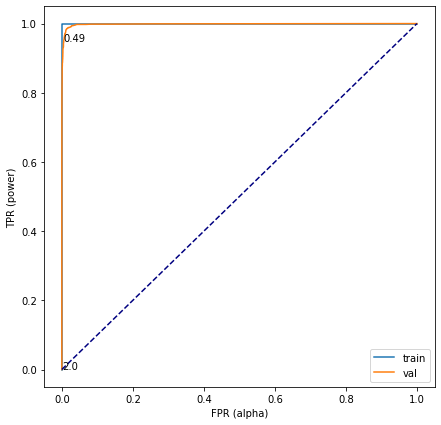

In [119]:
scores(rf_model_1 , X_train3 , X_val , y_train3 , y_val)
roc_plot(rf_model_1 , X_train3 , y_train3 , X_val , y_val)

train: 1.0 test: 0.98
{'max_depth': 10, 'min_samples_leaf': 5}
CPU times: user 9.28 s, sys: 514 ms, total: 9.8 s
Wall time: 5min 37s


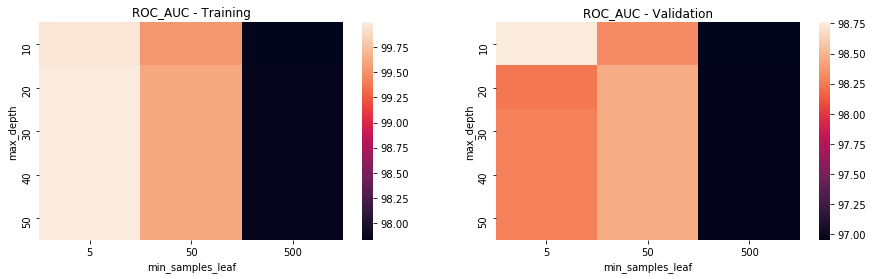

In [125]:
%%time
param_grid = {'max_depth':range(10,50+1,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(rf_model_1,param_grid,cv=5,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

#Plotting Roc Curve

train: 0.98 test: 0.98


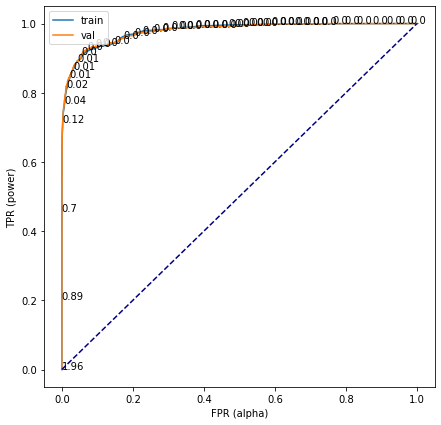

In [126]:
scores(best_model,X_train3,X_val,y_train3,y_val)
roc_plot(best_model,X_train3,y_train3,X_val,y_val)

train: 1.0 test: 1.0
{'max_depth': 25, 'min_samples_leaf': 5}
CPU times: user 9.51 s, sys: 1.04 s, total: 10.6 s
Wall time: 14min 36s


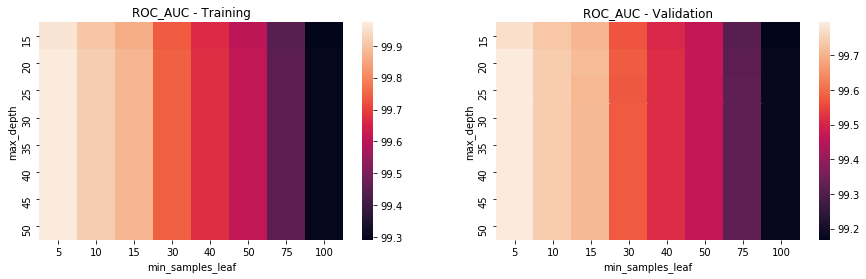

In [127]:
%%time
param_grid = {'max_depth':range(15,50+1,5),'min_samples_leaf':[5,10,15,30,40,50,75,100]}

opt_model = GridSearchCV(rf_model_1,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train3,y_train3)
best_model = opt_model.best_estimator_

scores(best_model,X_train3,X_val,y_train3,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

#GridSearch Optimization for XGBoost

In [128]:
model = XGBClassifier(random_state = 42)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

train: 1.0 test: 1.0


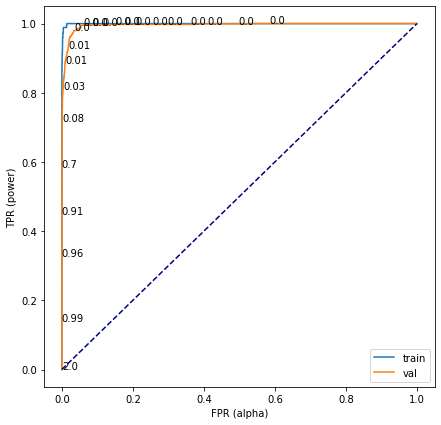

In [129]:
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

train: 0.99 test: 1.0
{'max_depth': 10, 'min_samples_leaf': 5}
CPU times: user 8.39 s, sys: 287 ms, total: 8.68 s
Wall time: 6min 12s


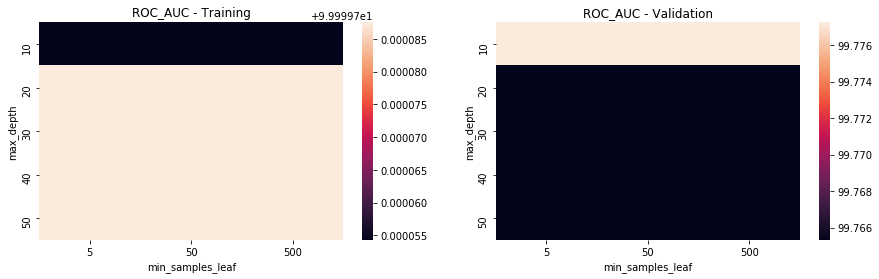

In [132]:
%%time
param_grid = {'max_depth':range(10,50+1,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train3,X_val,y_train3,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

#Visualization of ROC-Curve of Best HyperParemeter for XGBoost

train: 1.0 test: 1.0


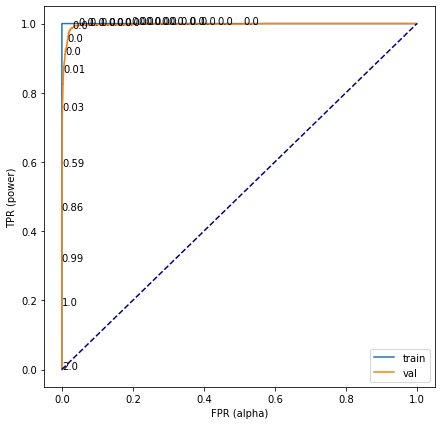

In [133]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

# Observation :

- Both Random Forest Model And XGBoost both return 100% on both training and testing after HyperParameter tunning using Gridsearch

# Visualization of Confusion Matrix

In [0]:
predictions = model.predict(X_test3)


In [151]:
from sklearn.metrics import confusion_matrix

# Print confusion matrix
cnf_matrix = confusion_matrix(y_test3, predictions)
print('Confusion Matrix:\n', cnf_matrix)


Confusion Matrix:
 [[9945    0]
 [ 616 1082]]


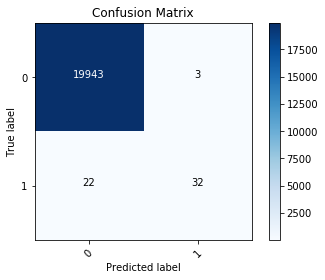

In [149]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Create the basic matrix
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(target) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

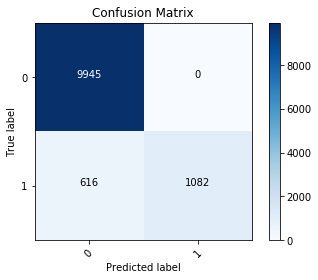

In [152]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Create the basic matrix
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(target) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

# 

# Plot a normalized confusion matrix


Normalized confusion matrix
[[1.         0.        ]
 [0.36277974 0.63722026]]


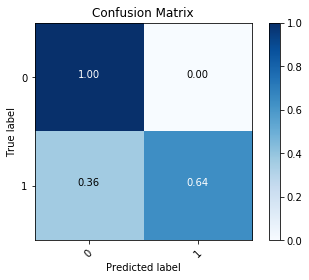

In [154]:
# Plot a normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


# 4. Machine Learning Pipeline

- Pipeline is mainly used to combine multiple models or estimator.
  
*  It simplifies the process where more than one model is required or used.
*  Once all the data is fit into the models or estmators , the predict method can be called.
*  All models in the pipeline must be transformers. The last model can either be a transformer or a classifier , regressor or other such objects.


- Pipelines are useful tools to write clean and meaningful code , for machine learning . Creating a model takes many steps such as clean data , transform it , potentially use it for feature selection and then run a Machine Learning algorithm.
- Using pipelines we can do all these steps in one go.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [0]:
# Create the pipeline
pipe = Pipeline([('scl', MinMaxScaler()),
                ('pca', PCA(n_components=7)),
                ('xgb', XGBClassifier())])
# Create the grid parameter
grid = [{'xgb__n_estimators': [100],
         'xgb__learning_rate': [0.05, 0.1], 
         'xgb__max_depth': [3, 5, 10],
         'xgb__colsample_bytree': [0.7, 1],
         'xgb__gamma': [0.0, 0.1, 0.2]
                }]
# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)
# Fit using grid search
gridsearch.fit(X_train, y_train)
# Best accuracy
print('Best accuracy: %.3f' % gridsearch.best_score_)
# Best params
print('\nBest params:\n', gridsearch.best_params_)


Best accuracy: 0.995

Best params:
 {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.2, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100}




# 5.   Feature Importance



*Let's check which features are the most influnecial from both models*

**Plot the most important features based on the Random Forest**

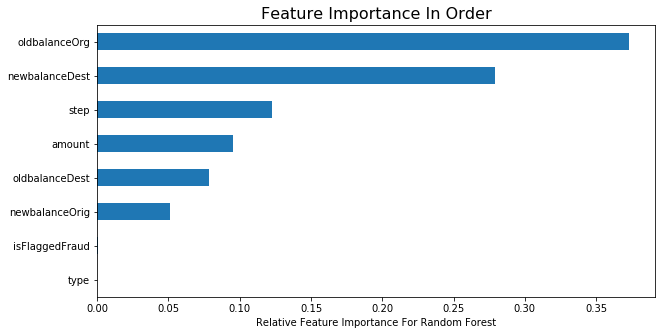

In [0]:
feat_importance = pd.Series(rf_model.feature_importances_ , index = features.columns)
ax.set_ylabel("features" , size = 16);
feat_importance.nlargest(10).sort_values().plot(kind = "barh" , figsize = (10 , 5))
plt.xlabel("Relative Feature Importance For Random Forest");
plt.title("Feature Importance In Order For Random Forest" , size = 16);

**Plot the important features based on XGBoost**

In [0]:
from xgboost import plot_importance

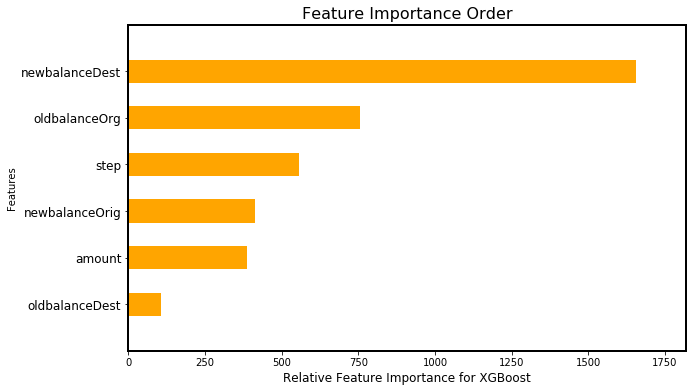

In [0]:
fig = plt.figure(figsize = (10 , 6))
ax = fig.add_subplot(111)
colours = plt.cm.Set1(np.linspace(0,1,9))
ax = plot_importance(xgb_model , height = 0.5 , color = "orange" , grid = False , \
                     show_values = False , importance_type = "cover" ,ax = ax );
for axis in ["top" , "bottom", "left" , "right"]:
  ax.spines[axis].set_linewidth(2)
  ax.set_xlabel("Relative Feature Importance for XGBoost" , size = 12);
  ax.set_yticklabels(ax.get_yticklabels() , size =12);
  ax.set_title("Feature Importance Order for XGBoost" , size = 16);

# Observations : 
- We can see that the most important features of the random forest model is the OldBalanceDest ,NewBalanceDest and  Step

- XGBoost's most important features are newbalance , oldbalanceOrg and Step.

- Each Model gives different importance to the features ; however , oldbalanceOrg and newbalanceDest are the major indicators for both models

# Conclusion:

- Most important features are senders balance before the transaction (oldBalanceOrig) and receivers balance after the transaction (newBalanceDest). 



### EDA Findings

- Eventhough safe transactions slows down in 3rd and 4th day and after 16th day of the month, fraud transactions happens at a steady pace. Especially in the second half of the month there are much less safe transactions but number of fraud transactions does not decrease at all. 
- Fraud proportion over all transactions is 0.01% while the fraud amount proportion is 0.1%
- There is some sort of seasonality in the number of transaction every 24 hours.Fraud transactions does not show that significant pattern. They happen every hour almost in the same frequency.
- There are more fraud transactions in low amounts and less in high amount. This distribution does not change much.
- Fraud transaction happens in a large range such as $119 dolars to $10M dolars. Most of the fraud transactions are of Lesser amount. But in 1M there is an interesting increase similar to safe transactions. 
- There are 16 fake fraud cases  with '0' amount.
- Fraud activities only happens with TRANSFER and CASH_OUT transactions. DEBIT usage is very safe.


## Accuracy results after iterations


In [0]:
I created a model that can predict fraud transactions. I used XGBoost and RandomForest  classifiers in this model. 

      (Data & Parameters)                              (Accuracy)     XGBoost   RandomForest
     
    **Iteration 1**                                                            
    - Random Sample & default parameters                                100%       83%  
      
    **Iteration 2** 
    - Random Sample & best parameters                                   85.5%     84.3%
      
    **Iteration 3**
    - Balanced data with SMOTE & best parameters                        99.4%     98.7% 
      
    **Iteration 4**
    - Random Safe trans. data and all Fraud data & best parameters      98.8%     99.6%
     
    **Iteration 5**
    - New data balanced with SMOTE & best parameters                    99%       92.1%

    **Final Iteration**
    - New Balanced data with SMOTE & best HpyerParametr Tuning .       100%      100%

# Additional Read:

Interpretation of classification reports

- Precision

Precision is the ability of a classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”

- Recall

Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”

- f1 score

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

- support

Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.
